In [1]:
import functools
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K

/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(xtrain, ytrain), (xtest, ytest) = keras.datasets.mnist.load_data()
xtrain, xtest = (x[:,:,:,np.newaxis]/255 for x in (xtrain, xtest))

In [3]:
X = X_input = keras.layers.Input((28,28,1))
X = keras.layers.Flatten()(X)
X = keras.layers.Dense(10, activation='softmax')(X)
M = keras.Model(X_input, X)
M.compile('adam', 'sparse_categorical_crossentropy', ['acc'])
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [4]:
M.fit(xtrain, ytrain, validation_data=(xtest, ytest), batch_size=64, epochs=5, callbacks=[
    keras.callbacks.ReduceLROnPlateau(patience=2, verbose=1)
])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 43us/step - loss: 0.5503 - acc: 0.8591 - val_loss: 0.3356 - val_acc: 0.9112
Epoch 2/5
60000/60000 [==============================] - 2s 34us/step - loss: 0.3254 - acc: 0.9101 - val_loss: 0.2946 - val_acc: 0.9204
Epoch 3/5
60000/60000 [==============================] - 2s 34us/step - loss: 0.2962 - acc: 0.9167 - val_loss: 0.2809 - val_acc: 0.9224
Epoch 4/5
60000/60000 [==============================] - 2s 34us/step - loss: 0.2827 - acc: 0.9211 - val_loss: 0.2749 - val_acc: 0.9236
Epoch 5/5
60000/60000 [==============================] - 2s 34us/step - loss: 0.2742 - acc: 0.9233 - val_loss: 0.2728 - val_acc: 0.9240


In [5]:
@functools.lru_cache()
def get_grad_curv(i):
    print(f'generating grad model of digit {i}')
    X = M(X_input)
    X = %time keras.layers.Lambda( \
        lambda x,i: K.gradients(x[1][:,i], x[0])[0], \
        output_shape=(28,28,1), \
        arguments={'i':i})([X_input, X])
    G = keras.Model(X_input, X)
    G.compile('adam', 'mse')
    print(f'generating curv model of digit {i}')
    X = G(X_input)
    def compute_hessian(x):
        return K.stop_gradient(K.reshape(K.stack([
            K.gradients(x[1][:,iy,ix,:], x[0])[0]
            for iy in range(28)
            for ix in range(28)
        ], axis=1), (-1,28,28,1,28,28,1)))
    def compute_curv(x):
        h = compute_hessian(x)
        return K.stop_gradient(K.reshape(K.stack([
            h[:,iy,ix,:,iy,ix,:]
            for iy in range(28)
            for ix in range(28)
        ], axis=1), (-1,28,28,1)))
    X = %time keras.layers.Lambda( \
        compute_curv, output_shape=(28,28,1))([X_input, X])
    C = keras.Model(X_input, X)
    C.compile('adam', 'mse')
    return G,C

In [29]:
def test_plot(test_label, improve_as):
    G,C = get_grad_curv(improve_as)
    test_idx = np.random.choice(np.where(ytest == test_label)[0])
    test = xtest[test_idx:test_idx+1]
    pred = M.predict(test)
    grad = G.predict(test)
    curv = C.predict(test)
    digit = np.argmax(pred[0])
    plt.figure(figsize=(12,4))
    plt.suptitle(f'labeled as {test_label}, predicted as {digit} ({pred[0,digit]:.4f}), improve to be {improve_as}', fontsize=16)
    plt.subplot(1,3,1)
    plt.title('input')
    plt.imshow(test[0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.title('gradients')
    plt.imshow(grad[0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.title('curvatures')
    plt.imshow(curv[0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.show()

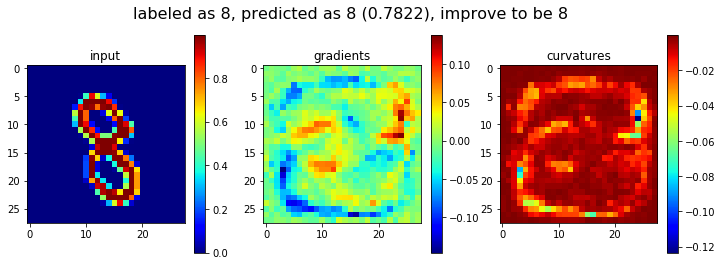

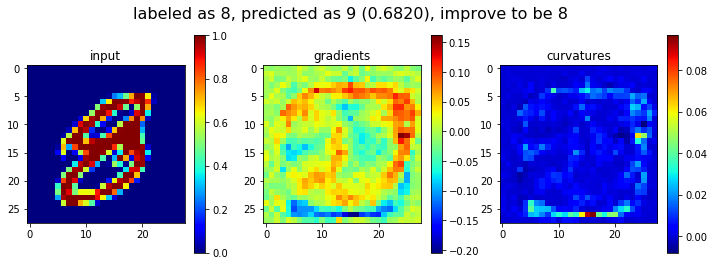

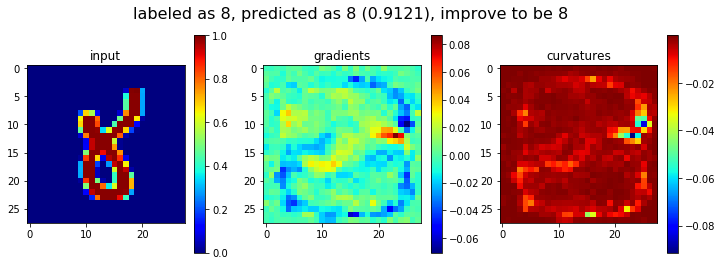

In [34]:
for _ in range(3):
    test_plot(8, 8)

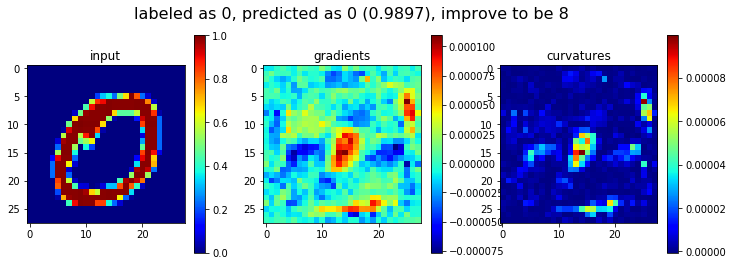

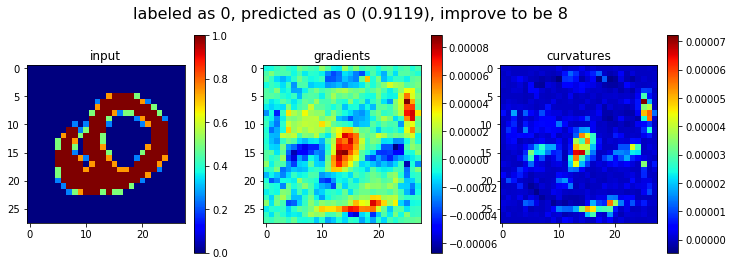

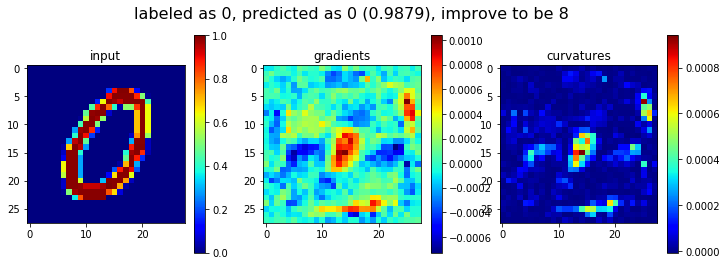

In [31]:
for _ in range(3):
    test_plot(0, 8)

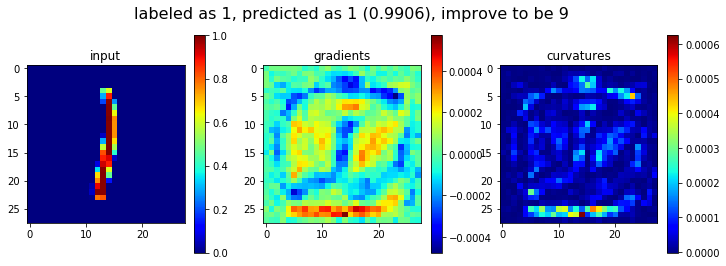

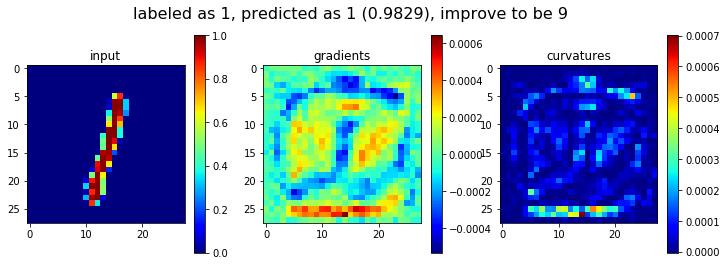

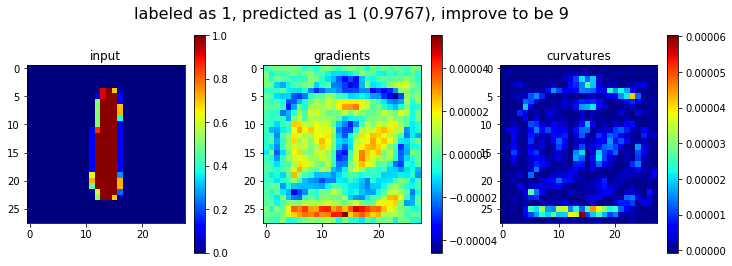

In [32]:
for _ in range(3):
    test_plot(1, 9)